# Случайные процессы. Прикладной поток.
## Практическое задание 6

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 6"`. Квадратные скобки обязательны. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `6.N.ipynb` и `6.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* При проверке могут быть запущены функции, которые отвечают за генерацию траекторий винеровского процесса.

------------------

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### 1. Генерация винеровского процесса

Генерировать траектории винеровского процесса можно двумя способами:

1. На отрезке $[0, 1]$ траектория генерируется с помощью функций Шаудера. Описание данного метода было рассказано на лекции. Его можно найти так же в книге *А.В. Булинский, А.Н. Ширяев - Теория случайных процессов*.

2. На отрезке $[0, \pi]$ траекторию можно с помощью следующей формулы
$$W_t = \frac{\xi_0 t}{\sqrt{\pi}} +\sqrt{\frac{2}{\pi}}\sum\limits_{i=1}^{+\infty} \frac{\sin(kt)}{k} \xi_k,$$
где $\{\xi_n\}$ --- независимые стандартные нормальные случайные величины.

Траектория для $\mathbb{R}_+$ генерируется с помощью генерирования отдельных траекторий для отрезков длины 1 или $\pi$ (в зависимости от метода) с последующим непрерывным склеиванием.

Генерацию траекторий одним из этих способов вам нужно реализовать. Ваш вариант можете узнать из файла с распределением.

Напишите класс, который будет моделировать винеровский процесс.
Из бесконечной суммы берите первые $n$ слагаемых, где число $n$ соответствует параметру `precision`.
Интерфейс должен быть примерно таким (подчеркивания обязательны!):

In [2]:
class WinerProcess:
    def __init__(self, precision=10000):
        self._precision = precision
        self._xi = [sps.norm.rvs(size=self._precision)]  # здесь будут \xi_k^t, где t - номер отрезка
        self._starts = [0, self._xi[0][0]]  # значения W_t для целых t
        self._log = False
        
        self._k = [0.5] + list(range(1, self._precision))
        self._n = np.log2(self._k).astype(int)
        self._a_nk = 2.**(- self._n)*(self._k - 2. ** self._n)
        
        if self._log:
            print("k = {}\n n = {}\n a_nk = {}\n".format(self._k, self._n, self._a_nk))
        
    def __getitem__(self, times):
        times = np.array(times)
        if times.max() >= len(self._xi):
            addition = int(times.max() + 1.) - len(self._xi)
            add_xi = sps.norm.rvs(size=(addition, self._precision))
            self._starts += list(self._starts[-1] + np.cumsum(add_xi[:, 0]))
            self._xi += list(add_xi)
            
        W = []
        for t in times:
            t_fractional_part = t - int(t)
            t_integer_part = int(t)
            
            positive_slope = (
                (self._a_nk <= t_fractional_part)
                & (t_fractional_part <= self._a_nk + 2.**(-self._n - 1))
            )
            negative_slope = (
                (self._a_nk + 2.**(-self._n - 1) < t_fractional_part)
                & (t_fractional_part <= self._a_nk + 2.**(-self._n))
            )

            Sk_in_positive_slopes = (
                2. ** (- (self._n[positive_slope] / 2.) - 1)
                * (t_fractional_part - self._a_nk[positive_slope])
                / (2. ** (-self._n[positive_slope] - 1))
            )
            Sk_in_negative_slopes = (
                2. ** (- (self._n[negative_slope] / 2.) - 1)
                * (self._a_nk[negative_slope] + 2.**(-self._n[negative_slope]) - t_fractional_part)
                / (2. ** (-self._n[negative_slope] - 1))
            )

            Sk = np.zeros(self._precision)
            Sk[positive_slope] = Sk_in_positive_slopes
            Sk[negative_slope] = Sk_in_negative_slopes
            Sk[0] = t_fractional_part
            
            if (self._log):
                print("Shauder's function at t = ", t)
                print("positive_slopes = ", positive_slope)
                print("negative_slopes = ", negative_slope)
                print("Sk(t) values = ", Sk)
                         
            W.append(self._starts[t_integer_part] + self._xi[t_integer_part] @ Sk)
        return W

In [3]:
_n = 10
_xi = [sps.norm.rvs(size=_n + 1)]  # здесь будут \xi_k^t, где t - номер отрезка
_starts = [0.]  # значения W_t для целых t
            
times = [0., 0.5, 1., 1.5, 2.]
times = np.array(times)
if times.max() >= len(_starts):
    addition = int(times.max() + 1.) - len(_starts)
    add_xi = sps.norm.rvs(size=(addition, _n))
    _starts += list(_starts[-1] + add_xi[:, 0])
    _xi += list(add_xi)

k = [0.5] + list(range(1, _n + 1))
n = np.log2(k).astype(int)
a_nk = 2.**(- n)*(k - 2. ** n)

print(k, n, a_nk)

t = 1./8.
positive_slope = (a_nk <= t) & (t <= a_nk + 2.**(-n - 1))
negative_slope = (a_nk + 2.**(-n - 1) < t) & (t <= a_nk + 2.**(-n))
print(positive_slope,"\n", negative_slope)

Sk_in_positive_slopes = (
    2. ** (- (n[positive_slope] / 2.) - 1) *
    (t - a_nk[positive_slope]) / (2. ** (-n[positive_slope] - 1))
)
Sk_in_negative_slopes = (
    2. ** (- (n[negative_slope] / 2.) - 1) *
    (a_nk[negative_slope] + 2.**(-n[negative_slope]) - t) / (2. ** (-n[negative_slope] - 1))
)

print(Sk_in_positive_slopes, "\n", Sk_in_negative_slopes)
Sk = np.zeros(_n + 1)
Sk[positive_slope] = Sk_in_positive_slopes
Sk[negative_slope] = Sk_in_negative_slopes
Sk[0] = t
print("Sk = ", Sk)
print(_xi)
_starts[int(t)] + _xi[int(t)] @ Sk

[0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] [-1  0  1  1  2  2  2  2  3  3  3] [ 0.     0.     0.     0.5    0.     0.25   0.5    0.75   0.     0.125
  0.25 ]
[ True  True  True False  True False False False False  True False] 
 [False False False False False False False False  True False False]
[ 0.08838835  0.125       0.1767767   0.25        0.        ] 
 [ 0.]
Sk =  [ 0.125      0.125      0.1767767  0.         0.25       0.         0.         0.
  0.         0.         0.       ]
[array([-0.80563936, -1.24944006, -0.59979475, -1.02410872, -0.29901853,
        1.28749505,  0.30973738,  0.47673639,  0.71610623,  0.82247709,
        0.44498507]), array([ 1.11873947, -0.86993521,  2.08415158, -0.12365194, -1.25229957,
        0.63568484, -2.25331515,  0.5252042 ,  0.47271093, -0.63483824]), array([-0.00866823, -0.90644725,  0.58492377,  0.68575626, -0.23613395,
       -1.35761448, -0.53041384, -1.16553853, -1.5675932 , -0.48847711])]


-0.43766929399358501

* Экземпляр класса должен представлять некоторую траекторию винеровского процесса. Это означает, что один и тот же экземпляр класса для одного и того же момента времени должен возвращать одно и тоже значение. Разные экземпляры класса --- разные (п.н.) траектории.

* Метод `__init__` (конструктор) должен запоминать число слагаемых в сумме (`precision`), а также (может быть) генерировать необходимые случайные величины для начального отрезка.

* Метод `__getitem__` должен принимать набор моментов времени и возвращать значения траектории винеровского процесса в эти моменты времени. При необходимости можно сгенерировать новые случайные величины. Используйте то, что запись `x.__getitem__(y)` эквивалентна `x[y]`.

* Для получения полного балла и быстро работающего кода реализация должна содержать не более одного явного цикла (по отрезкам при непосредственной генерации). Вместо всех остальных циклов нужно использовать функции библиотеки `numpy`.

* Внимательно проверьте отсутствие разрывов траектории в точках, кратных $\pi$.

* Имена любых вспомогательных методов должны начинаться с одного подчеркивания.

* В реализации желательно комментировать (почти) каждую строку кода. Это даже больше поможет вам, чем нам при проверке.

Сгенерируйте траекторию винеровского процесса и постройте ее график. Сгенерируйте еще одну траекторию и постройте график двумерного винеровского процесса. Графики должны быть похожими на графики с семинара.

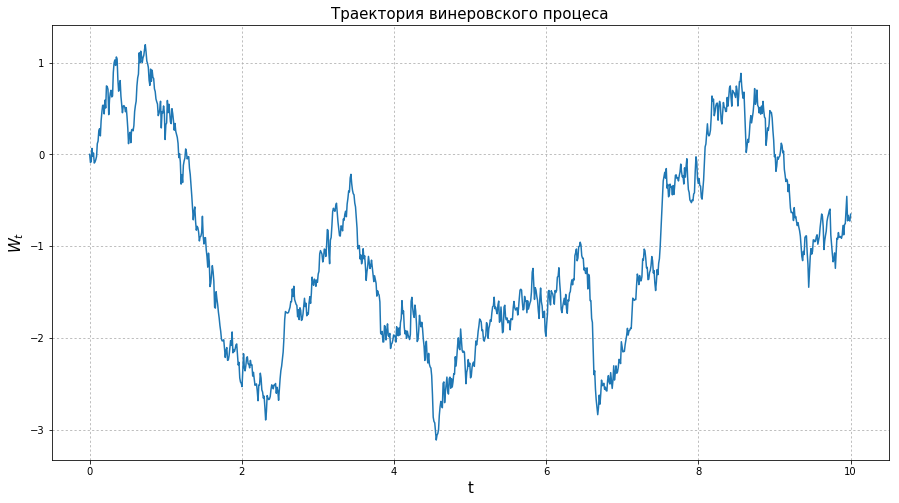

In [3]:
W = WinerProcess()
# W._log = True
T = np.linspace(0, 10, 1000)
plt.figure(figsize=(15, 8))
plt.plot(T, W[T])
plt.grid(ls=':')
plt.title("Траектория винеровского процеса", fontsize=15)
plt.xlabel("t", fontsize=15)
plt.ylabel("$W_t$", fontsize=15)
plt.show()

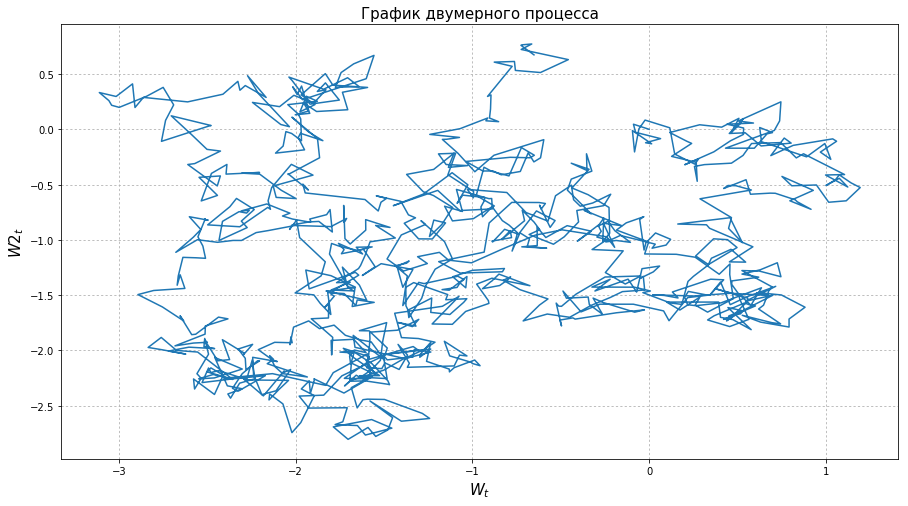

In [4]:
W2 = WinerProcess()
plt.figure(figsize=(15, 8))
plt.plot(W[T], W2[T])
plt.title("График двумерного процесса", fontsize=15)
plt.xlabel("$W_t$", fontsize=15)
plt.ylabel("$W2_t$", fontsize=15)
plt.grid(ls=':')
plt.show()

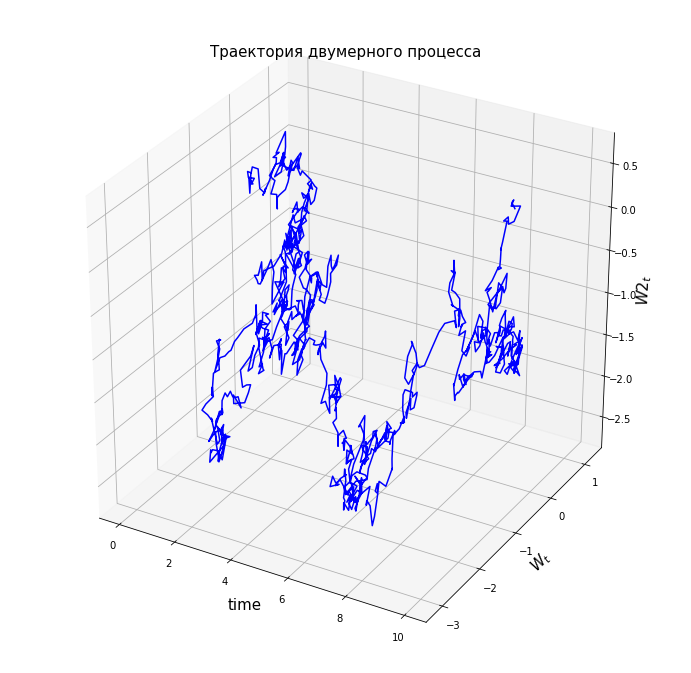

In [5]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
# ax.scatter(T, W[T], W2[T])
ax.plot(T, W[T], W2[T], color='b')
plt.title("Траектория двумерного процесса", fontsize=15)
ax.set_xlabel("time", fontsize=15)
ax.set_ylabel("$W_t$", fontsize=15)
ax.set_zlabel("$W2_t$", fontsize=15)
plt.show()

Допустим, для исследования свойств траекторий винеровского процесса нам нужно сгенерировать траекторию с хорошей точностью до достаточно большого значения $t$.
Какие проблемы могут возникнуть при использовании реализованного класса?
Для этого попробуйте запустить следующий код.

In [6]:
%time
Wt = WinerProcess()  # WinerProCCess()
t = np.linspace(0, 10 ** 7, 10 ** 5)
values = Wt[t]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.4 µs


MemoryError: 

Опишите подробно причину проблемы, которая в данном случае возникает.

**Описание:** Для моделирования процесса через функции Шаудера нужно precision случайных величин на каждый отрезок [0,1]. Итого, для точного моделирования нужно слишком много памяти, да и времени тоже.

При этом, если нам нужны значения только в целых точках, то из precision величин на каждом отрезке нас интересует только одна! (Та, у которой $S_k(1) \neq 0$, т.е. $\xi_0$.



Для избавления от таких проблем реализуйте следующую функцию:

In [7]:
def winer_process_path(end_time, step, precision=10000):
    # Моменты времени, в которые нужно вычислить значения
    times = np.arange(0, end_time, step)
    # Сюда запишите значения траектории в моменты времени times
    values = np.zeros_like(times)
    
    k = [0.5] + list(range(1, precision))
    n = np.log2(k).astype(int)
    a_nk = 2.**(- n)*(k - 2. ** n)

    W = []

    Wt = 0. 
    last_int_t = 0
    # поддерживаем значение процесса в целой точке,
    # самой правой среди рассмотренных в массиве times
    # (предполагаем, что он отсортирован)

    xi = sps.norm.rvs(size=(precision))
    # поддерживаем xi_i, сгенерированные для отрезка [last_int_t, last_int_t + 1]
    
    
    for t in times:
        t_fractional_part = t - int(t)
        t_integer_part = int(t)
        
        if (t_integer_part > last_int_t):
            Wt += xi[0]
            last_int_t += 1
            
            if (t_integer_part - last_int_t - 1 > 0):
                xi0 = sps.norm.rvs(size=(t_integer_part - last_int_t - 1)) 
                # для отрезков времени [x, x+1], где не спрашивают значение,
                # генерируем только xi0, т.к. другие не нужны
                Wt += xi0.sum()

            last_int_t = t_integer_part
            xi = sps.norm.rvs(size=(precision))

        positive_slope = (
            (a_nk <= t_fractional_part)
            & (t_fractional_part <= a_nk + 2.**(-n - 1))
        )
        negative_slope = (
            (a_nk + 2.**(-n - 1) < t_fractional_part)
            & (t_fractional_part <= a_nk + 2.**(-n))
        )

        Sk_in_positive_slopes = (
            2. ** (- (n[positive_slope] / 2.) - 1)
            * (t_fractional_part - a_nk[positive_slope])
            / (2. ** (-n[positive_slope] - 1))
        )
        Sk_in_negative_slopes = (
            2. ** (- (n[negative_slope] / 2.) - 1)
            * (a_nk[negative_slope] + 2.**(-n[negative_slope]) - t_fractional_part)
            / (2. ** (n[negative_slope] - 1))
        )

        Sk = np.zeros(precision)
        Sk[positive_slope] = Sk_in_positive_slopes
        Sk[negative_slope] = Sk_in_negative_slopes
        Sk[0] = t_fractional_part

        W.append(Wt + xi @ Sk)
    return times, W

In [15]:
# гораздо более экономный вариант реализации, конечно, нам не нужен
def winer_process_path_alpha(end_time, step, precision=10000):
    # Моменты времени, в которые нужно вычислить значения
    times = np.arange(0, end_time, step)
    # Сюда запишите значения траектории в моменты времени times
    values = np.zeros_like(times)
    
    W_step = sps.norm(scale=np.sqrt(step)).rvs(len(times) - 1)  # независимые приращения
    values[1:] = np.cumsum(W_step)
    return times, values

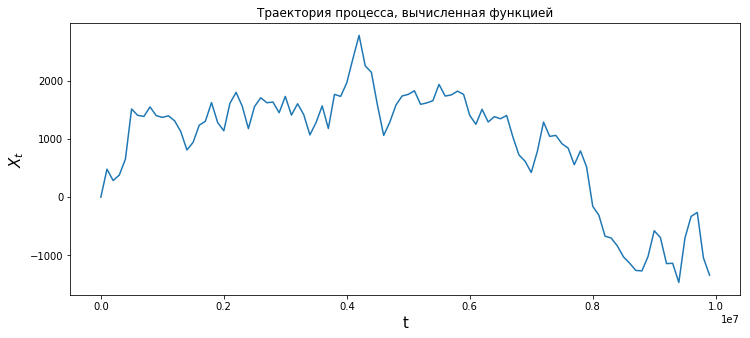

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(*winer_process_path(10 ** 7, 10 ** 5))
plt.title("Траектория процесса, вычисленная функцией")
plt.ylabel("$X_t$", fontsize=15)
plt.xlabel("t", fontsize=15)
plt.show()

Для получения полного балла и быстро работающего кода реализация должна содержать не более одного явного цикла (по отрезкам при непосредственной генерации). Вместо всех остальных циклов нужно использовать функции библиотеки `numpy`. Внутри этой функции можно реализовать вспомогательную функцию.

### 2. Исследования

**Следующая часть работы делается в паре.**

Для каждого их двух способов генерация траектрии винеровского процесса постройте таблицу $3 \times 3$ из графиков траекторий винеровского процесса.
По вертикали изменяйте количество $n$ используемых слагаемых в сумме ($n=10; 100; 1000$), по горизонтали --- длину отрезка, на котором генерируется винеровский процесс (использовать отрезки $[0, 10], [0, 1], [0, 0.1]$).
Обратите внимание, что от размера сетки зависит только точность отображения функции на графике, а не сама функция, поэтому сетку нужно выбирать достаточно мелкой.

In [11]:
class WinerProcess16:
    def __init__(self, precision=10000):
        self.N = precision
        self.ksi0 = [sps.norm.rvs(size=1)[0]]
        self.ksis = [[]]
        self.starts = [0]
        
    def __getitem__(self, times):
        times = np.array(times)
        if times.max() // np.pi >= len(self.ksi0):
            n_new = int(times.max() // np.pi) - len(self.ksi0) + 1
            new_ksi0 = sps.norm.rvs(size=n_new)
            self.starts.append(self.ksi0[-1] * np.sqrt(np.pi) + self.starts[-1])
            new_starts = np.cumsum(new_ksi0[:-1]) * np.sqrt(np.pi) + self.starts[-1]
            self.ksi0 += list(new_ksi0)
            self.starts += list(new_starts)
            self.ksis += [[] for i in range(n_new)]
        W = []
        for t in times:
            seg = int(t // np.pi)
            if len(self.ksis[seg]) == 0:
                self.ksis[seg] = sps.norm.rvs(size=self.N - 1)
            series_sum = np.sum(self.ksis[seg] * np.sin(np.arange(1, self.N) * (t - seg * np.pi)) / np.arange(1, self.N))
            Wt = self.starts[seg] + self.ksi0[seg] * (t - seg * np.pi) / np.sqrt(np.pi) + series_sum * np.sqrt(2 / np.pi)
            W.append(Wt)
        return np.array(W)

Мой класс


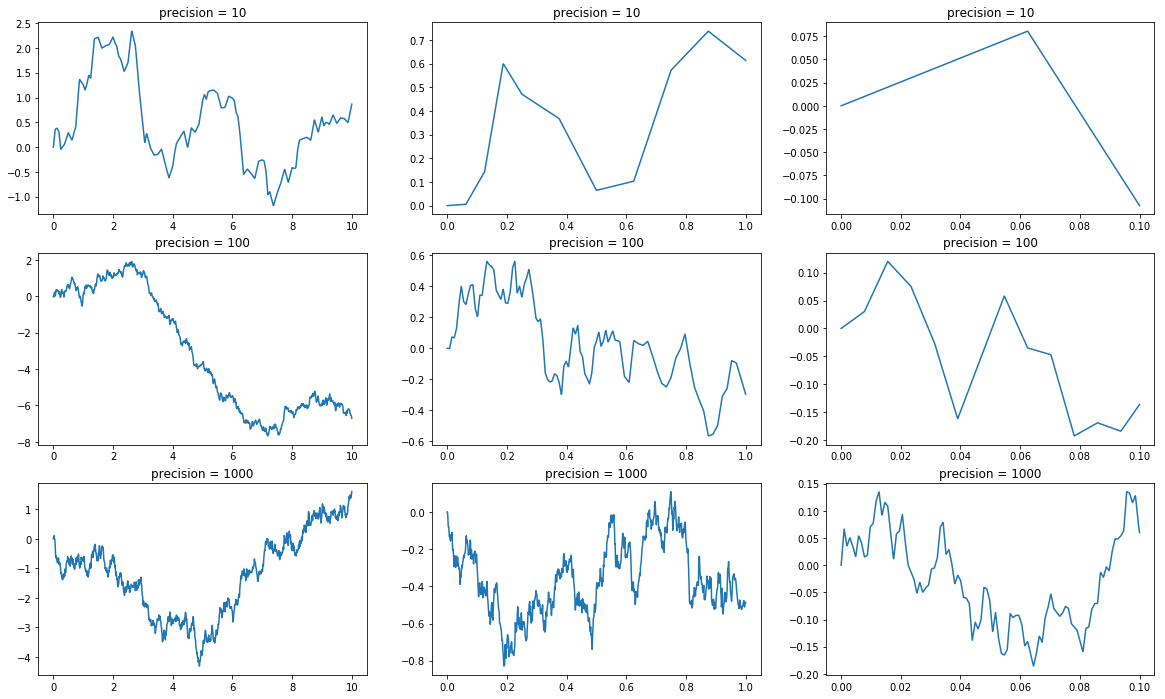

Класс напарника


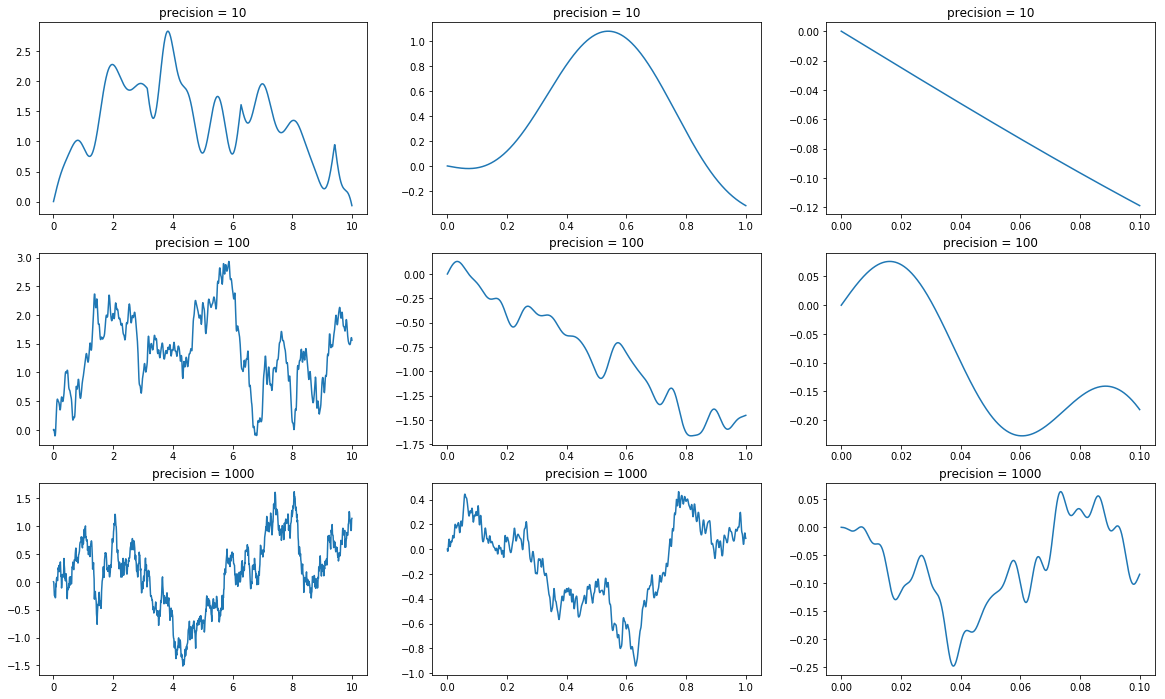

In [12]:
for WP, name in [(WinerProcess, "Мой класс"), (WinerProcess16, "Класс напарника")]:
    print(name)
    plt.figure(figsize=(20, 12))
    for i, precision in enumerate([10, 100, 1000]):
        for j, max_time in enumerate([10, 1, 0.1]):
            t = np.linspace(0, max_time, 1000)
            values = WP(precision=precision)[t]

            plt.subplot(3, 3, i * 3 + j + 1)
            plt.plot(t, values)
            plt.title('precision = %d' % precision)
    plt.show()

Какие выводы можно сделать про каждый способ генерации?

Сравните два способа генерации по времени работы.

In [18]:
%time times, values = winer_process_path_alpha(100000, 0.1)

CPU times: user 108 ms, sys: 16 ms, total: 124 ms
Wall time: 120 ms


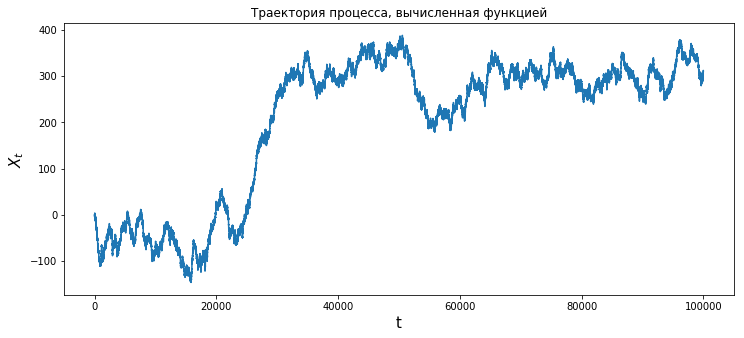

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(times, values)
plt.title("Траектория процесса, вычисленная функцией")
plt.ylabel("$X_t$", fontsize=15)
plt.xlabel("t", fontsize=15)
plt.show()

In [22]:
%time times, values = winer_process_path(100000, 0.1)

CPU times: user 55min 25s, sys: 7.6 s, total: 55min 33s
Wall time: 55min 39s


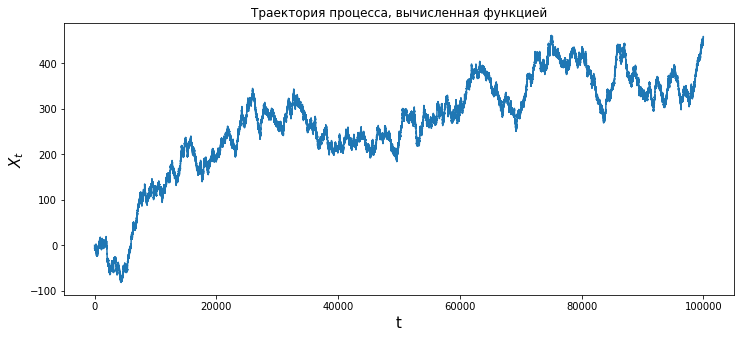

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(times, values)
plt.title("Траектория процесса, вычисленная функцией")
plt.ylabel("$X_t$", fontsize=15)
plt.xlabel("t", fontsize=15)
plt.show()

Постройте графики полученных траекторий для каждого способа? Отличаются ли траектории визуально?

Какие можно сделать выводы из сравнения двух способов генерации?

**Вывод:** т.к. мы расматриваем не всю сумму, а только некоторый её префикс, по полученное приближение зависит от природы ортонормированной системы, которую мы используем. 

При использовании гладкой тригонометрической системы, приближение так же получается гладким. При использовании функций Хаара, приближение получается более ломанными и угловатым.

В обоих случаях влияние системы уменьшается при росте рассматриваемого интервала и/или при росте точности, что логично.

**Следующая часть работы делается индивидуально.**

1. Сгенерируйте 100 траекторий винеровского процесса с достаточно хорошей точностью и нарисуйте их на одном графике? Что можно сказать про поведение траекторий?

2. Нарисуйте график двумерного винеровского процесса (см. презентацию с семинара).

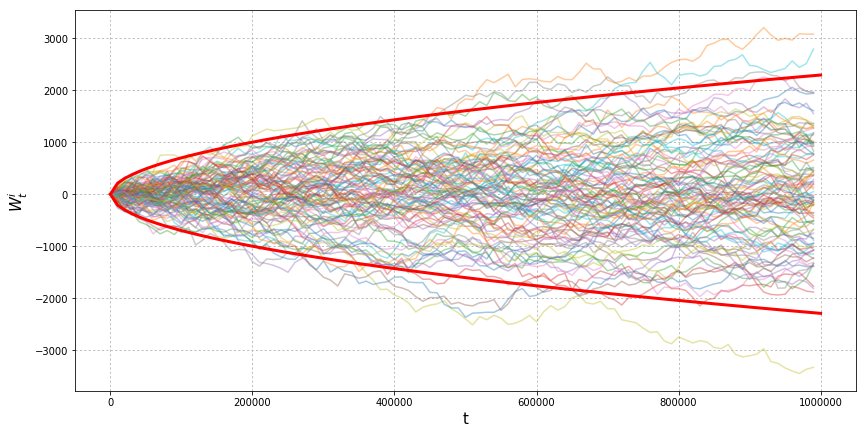

In [43]:
plt.figure(figsize=(14, 7))
max_time = 1000000
grid = np.linspace(np.e, max_time, 100)
for i in range(100):
    # print(i, end=",")
    times, values = winer_process_path(max_time, 10000)
    plt.plot(times, values, alpha=0.4)
plt.grid(ls=':')    
upper = np.sqrt(2 * grid * np.log(np.log(grid)))
lower = -np.sqrt(2 * grid * np.log(np.log(grid)))
plt.plot(grid, upper, color='red', lw=3)
plt.plot(grid, lower, color='red', lw=3)
plt.xlabel("t", fontsize=15)
plt.ylabel("$W_t^i$", fontsize=15)
plt.show()

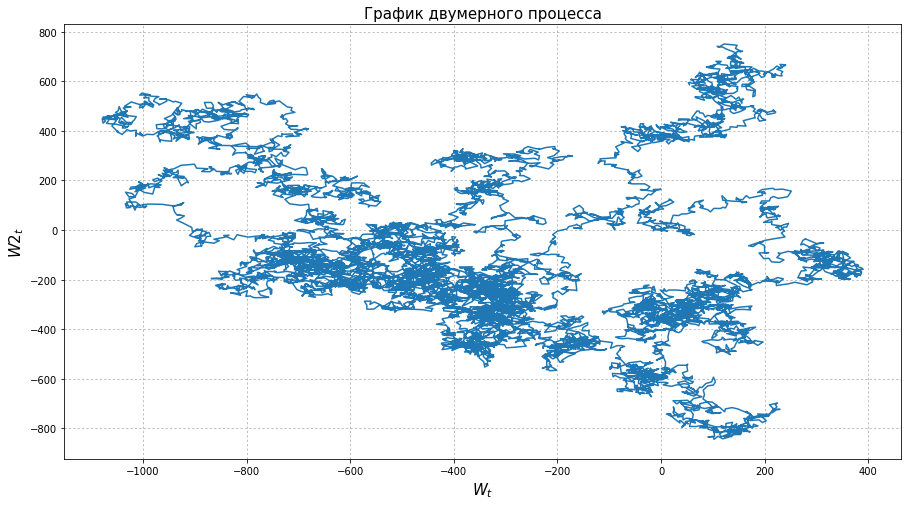

In [45]:
times, values_1 = winer_process_path(max_time, 100)
times, values_2 = winer_process_path(max_time, 100)

plt.figure(figsize=(15, 8))
plt.plot(values_1, values_2)
plt.title("График двумерного процесса", fontsize=15)
plt.xlabel("$W_t$", fontsize=15)
plt.ylabel("$W2_t$", fontsize=15)
plt.grid(ls=':')
plt.show()